<a href="https://colab.research.google.com/github/ekinfergan/Thesis_Jupyter_Final/blob/main/src/models/bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT

In [2]:
!git clone https://github.com/ekinfergan/Thesis_Jupyter_Final.git

Cloning into 'Thesis_Jupyter_Final'...
remote: Enumerating objects: 996, done.
remote: Counting objects: 100% (416/416), done.
remote: Compressing objects: 100% (259/259), done.
remote: Total 996 (delta 193), reused 366 (delta 155), pack-reused 580
Receiving objects: 100% (996/996), 191.33 MiB | 18.58 MiB/s, done.
Resolving deltas: 100% (511/511), done.
Updating files: 100% (86/86), done.


In [3]:
%cd Thesis_Jupyter_Final
!git pull
%cd ..

/Thesis_Jupyter_Final
Already up to date.
/


In [ ]:
%pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 104.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.5 MB/s eta 0:00:00


In [ ]:
%pip install -q torch

In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# To run in Google Colab
import io
#from google.colab import files
from IPython import get_ipython

# Other
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

google_colab = False

In [ ]:
# Set global params
class_names = ['Negative', 'Neutral', 'Positive']
print(len(class_names))

3


In [ ]:
# Set constants and initial variables
%config InlineBackend.figure_format='retina'

# Graph Designs #TODO
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
script_dir = os.path.dirname(os.path.abspath('bert.ipynb'))
data_path = os.path.join(script_dir, 'Thesis_Jupyter_Final/src/')
os.getcwd()
print(data_path)

input_folder_path = os.path.join(data_path, 'input')
processed_folder_path = os.path.join(data_path, 'input/processed/neg_tagged')
results_folder_path =  os.path.join(data_path, "results/BERT_results")

# Create the folder if it doesn't exist
if not os.path.exists(results_folder_path):
    os.makedirs(results_folder_path)

/content/Thesis_Jupyter_Final/src/


In [ ]:
os.getcwd()

'/content'

In [ ]:
# Choose file, if running on Google Colab. Otherwise, skip this cell.
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Get the current running kernel
ipython = get_ipython()

# Set a custom variable "google_colab" to True
if ipython:
    ipython.run_cell("google_colab = True")

## Load Data (& Remove Missing Values)

In [ ]:
def drop_missing(data):
    """
    Drop rows with missing values from a pandas DataFrame and return the cleaned DataFrame.

    Args:
        data (pandas.DataFrame): The input DataFrame containing the data.

    Returns:
        pandas.DataFrame: The cleaned DataFrame with missing values removed.
    """

    rows_before = data.shape[0]

    data.replace('', np.nan, inplace=True)
    data = data.dropna()
    data.reset_index(drop=True, inplace=True)
    rows_after = data.shape[0]

    print(f"Number of removed rows: {rows_before - rows_after}")  # Count the number of rows removed

    return data

def load_data(filename, process=True):
    """
    Loads data from a file and returns it as a pandas DataFrame.

    Args:
        filename (str): The name of the file to load.
        process (bool, optional): Whether to perform additional data processing steps (default is True).

    Returns:
        pandas.DataFrame: The loaded data as a DataFrame.

    Raises:
        FileNotFoundError: If the specified file is not found.
    """
    try:
        if google_colab:
            data_file_path = io.BytesIO(uploaded[filename])
        else:
            data_file_path = os.path.join(input_folder_path, filename)
        df = pd.read_csv(data_file_path)

        if process:
            df.set_index('Id', inplace=True, drop=True) # Set ID as index
            df = drop_missing(df)

        return df

    except FileNotFoundError:
        raise FileNotFoundError(f"Error: File '{filename}' not found.")


data_filename = "original_data.csv"
df = load_data(data_filename)

Number of removed rows: 0


Inspect loaded raw data.

In [ ]:
print(df.info())
print()
print(f'Dataset shape: {df.shape}\n')
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107018 entries, 0 to 107017
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Review     107018 non-null  object
 1   Sentiment  107018 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ MB
None

Dataset shape: (107018, 2)



,Review,Sentiment
0,good and interesting,3
1,"This class is very helpful to me. Currently, I...",3
2,like!Prof and TAs are helpful and the discussi...,3
3,Easy to follow and includes a lot basic and im...,3
4,Really nice teacher!I could got the point eazl...,3


## Preprocess Data

ML algorithms can't directly process raw text. Hence, text data must represented numerically. <br>
Handling this data representation is important for BERT.

For this purpose, we do the following transformations:
1. Add special tokens to distinguish between sentences.
2. Pad sequences to fixed length
3. Create array composed of 0s (representing pad tokens) and 1s (representing real tokens) known as attention mask.

We choose the 'bert-base-cased' configuration of the BERT model. <br>
'base' indicates a model with a smaller arhictecture consisting of 12 transformer layers, 768 hidden units and 12 attention heads. This totals to 110 million parameters <br>
'cased' indicates that the model differentiates between uppercase and lowercase letters. This will place more emphasis on upper case words e.g. "GOOD" vs "good". <br>
These configurations make the model more computationally efficient.

In [ ]:
# Set  model name
MODEL_NAME = 'bert-base-cased'

# Create a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
# Some of the commonly used BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id)  # Indicates the end of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id)  # Marks the beginning of each sentence, aiding BERT in classification
print(tokenizer.pad_token, tokenizer.pad_token_id)  # Special token used for padding
print(tokenizer.unk_token, tokenizer.unk_token_id)  # Represents tokens that are not found in the training set

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


Text(0.5, 0, 'Token count')

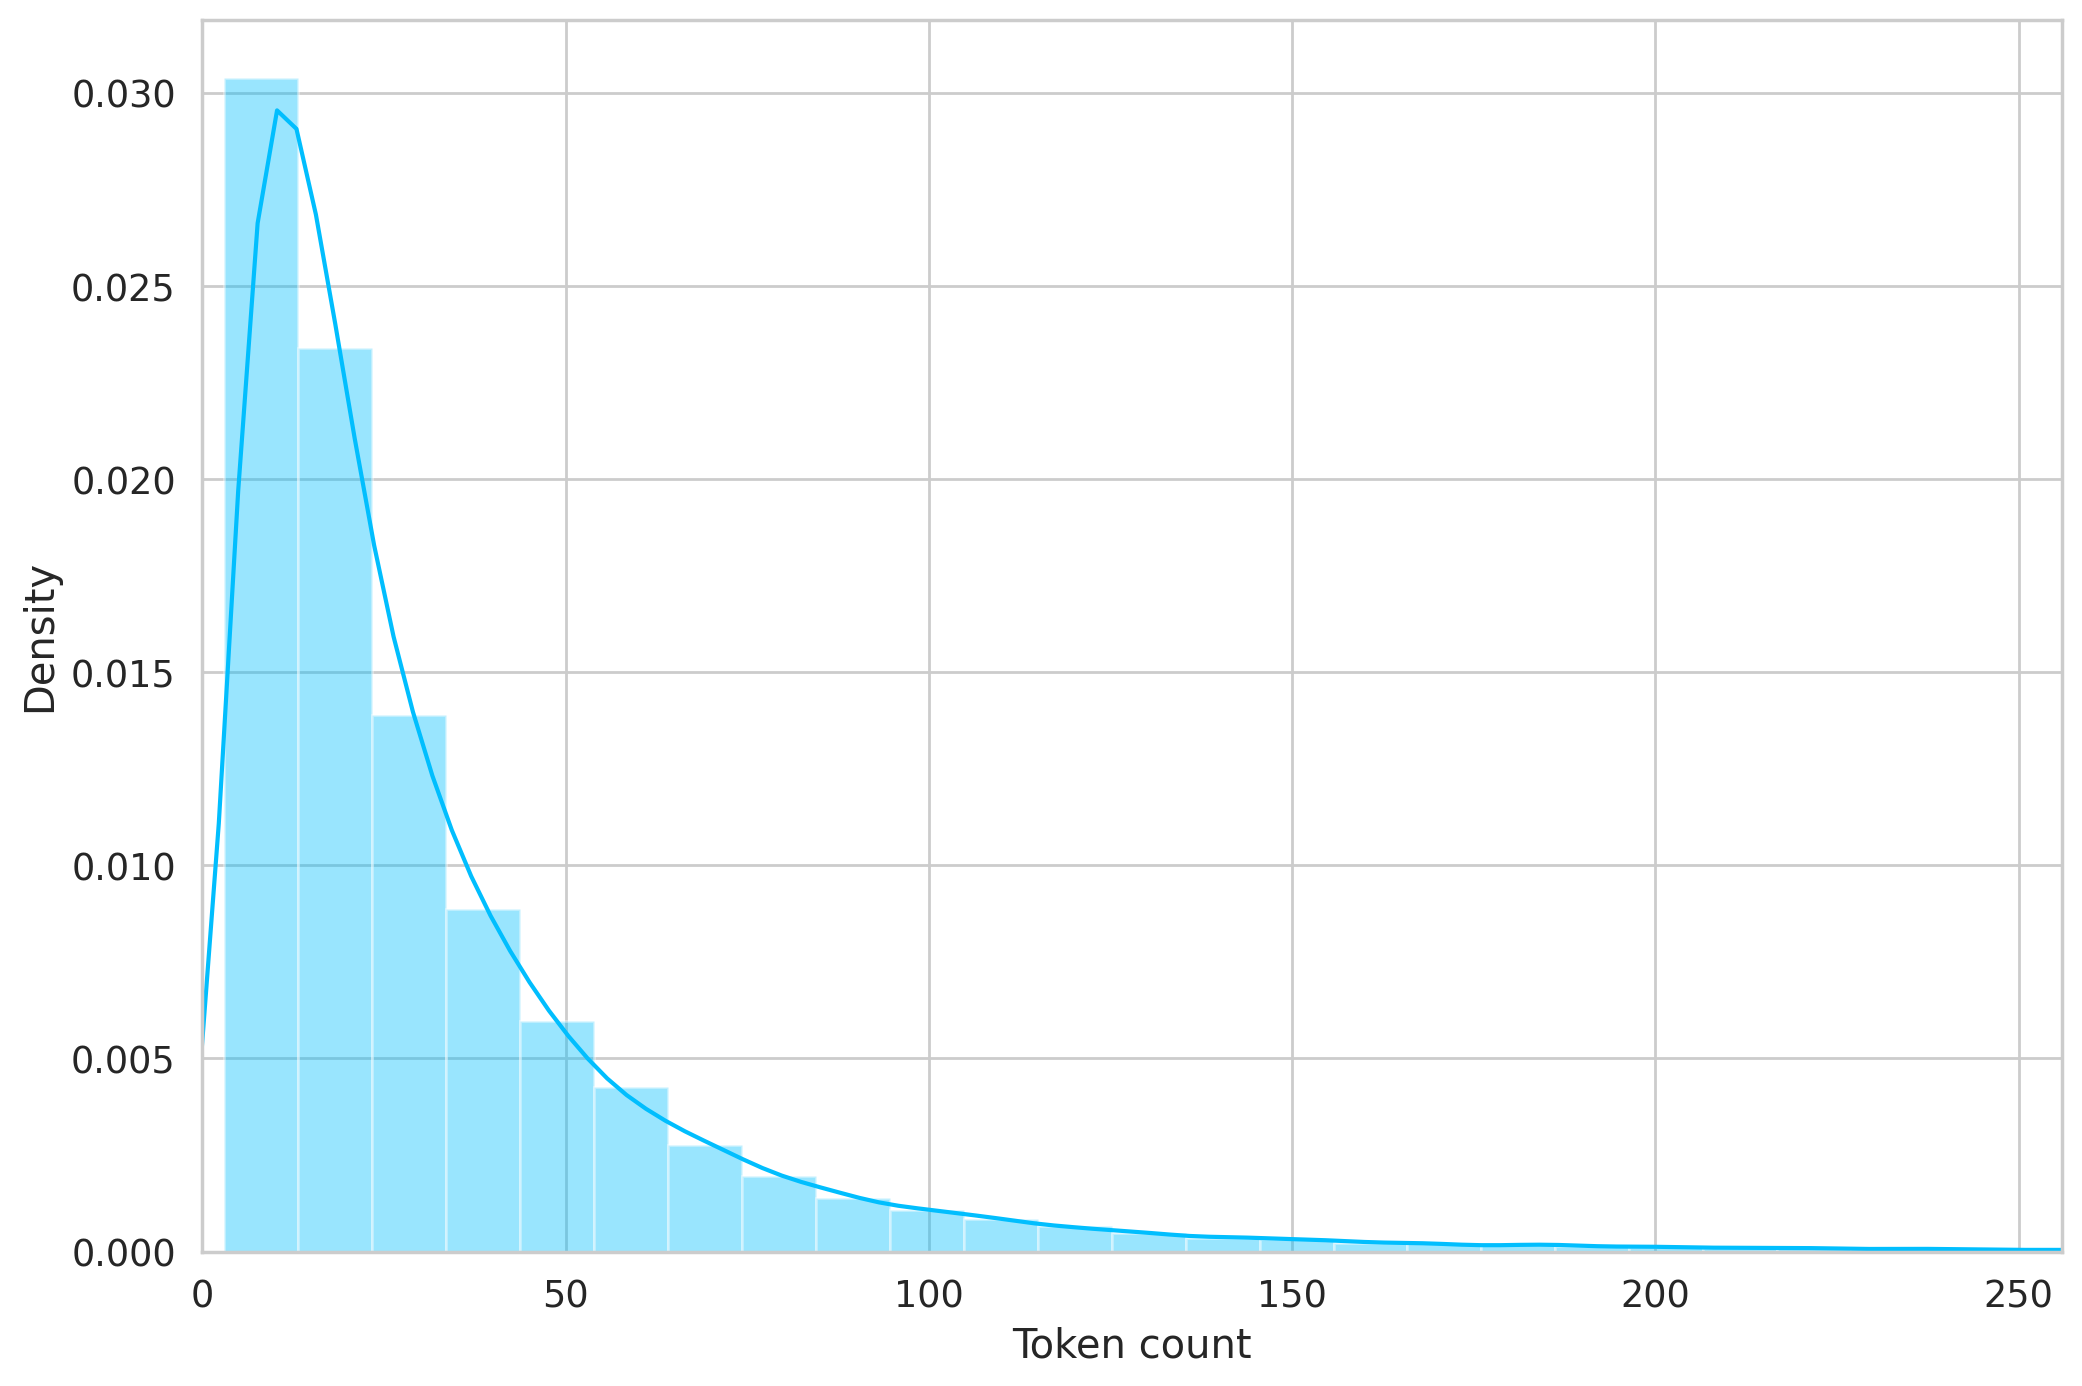

In [ ]:
# Calculate the length of each review in data
review_len = []
for review in df['Review']:
    tokens = tokenizer.encode(review, max_length=512)
    review_len.append(len(tokens))

# Create a distibuion plot of the review lengths
sns.distplot(review_len)
plt.xlim([0, 256]);
plt.xlabel('Token count')

Based on the analysis, it appears that the majority of the reviews have a token count of fewer than 150. However, to ensure comprehensive coverage, we will set a maximum length of 200 tokens for our processing.

### Set Constants

In [ ]:
MAX_LEN = 150
BATCH_SIZE = 16
EPOCHS = 4

# Preparing Data for PyTorch

Creating a robust data generator class is necessary to prepare the data for input into a PyTorch model. This class will be responsible for generating the data in a format suitable for training or validation.  Alongside other data that is generated or processed for the PyTorch model, we will  also include the original review text as an additional output. By including the option to return the text, we can easily compare the predicted results with the actual review text and assess the accuracy and relevance of the model's predictions.

In [ ]:
class ReviewDataset(Dataset):
    """
    PyTorch dataset class for sentiment analysis on reviews.
    """
    def __init__(self, reviews, targets, tokenizer, max_len):
        """
        Initializes the ReviewDataset.

        Args:
            reviews (list): List of review texts.
            targets (list): List of target sentiment labels.
            tokenizer (transformers.PreTrainedTokenizer): Tokenizer for encoding the reviews.
            max_length (int): Maximum length of the encoded input sequences.
        """

        self.reviews = reviews
        self.targets = targets - 1  # -1 since the target data is [1,2,3]
        self.tokenizer = tokenizer
        self.max_len = max_len


    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
            int: Length of the dataset.
        """

        return len(self.reviews)


    def __getitem__(self, item):
        """
        Retrieves an item from the dataset.

        Args:
            index (int): Index of the item to retrieve.

        Returns:
            dict: Dictionary containing the review text, input IDs, attention mask, and target sentiment label.
        """

        review = str(self.reviews[item])
        target = self.targets[item]

        # Encode the review text
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            return_token_type_ids=False,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        sample_dict =  {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),   # The numerical token IDs assigned to each word
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
            }

        return sample_dict

## Split Data into Train, Validation and Test Set

In [ ]:
# Split the data into train and test/validation
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)

# Further split the test/validation data into test and validation
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print("Train: ", df_train.shape)
print("Validation: ", df_val.shape)
print("Test:", df_test.shape)

Train:  (85614, 2)
Validation:  (10702, 2)
Test: (10702, 2)


In [ ]:
def build_data_loader(df, tokenizer, max_len, batch_size):
    """
    Creates a PyTorch DataLoader interface for efficient data loading and batching
    during training or evaluation.

    Args:
        df (pandas.DataFrame): DataFrame containing the review and sentiment data.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for encoding the reviews.
        max_len (int): Maximum length of the encoded input sequences.
        batch_size (int): Number of samples per batch.

    Returns:
        torch.utils.data.DataLoader: DataLoader object for iterating over batches of data.
    """

    created_dataset = ReviewDataset(reviews=df['Review'].to_numpy(),
                                    targets=df['Sentiment'].to_numpy(),
                                    tokenizer=tokenizer,
                                    max_len=max_len)

    return DataLoader(created_dataset, batch_size=batch_size, num_workers=0)

# Create data loader for train, test and val data
train_data_loader = build_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = build_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = build_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# Example of a data sample
batch_data = next(iter(train_data_loader))    # Retrieve next batch of data
print(batch_data.keys())
print(batch_data['input_ids'].shape)    # Number of samples in the batch vs. sequence length
print(batch_data['attention_mask'].shape)
print(batch_data['targets'].shape)  # Output shows only one dimension representing targets

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 200])
torch.Size([16, 200])
torch.Size([16])


## Sentiment Classification

In [ ]:
# Load the basic BERT model
bert_model = BertModel.from_pretrained(MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class SentimentClassifier(nn.Module):
    """
    Sentiment classifier model based on BERT for sentiment analysis.
    """

    def __init__(self, num_classes):
        """
        Initializes the SentimentClassifier.

        Args:
            num_classes (int): Number of sentiment classes for classification.
        """

        super(SentimentClassifier, self).__init__()
        self.bert_model = BertModel.from_pretrained(MODEL_NAME, return_dict=False)
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert_model.config.hidden_size, num_classes)  # Fully connected (linear) layer


    def forward(self, input_ids, attention_mask):
        """
        Forward propagation of the SentimentClassifier.

        Args:
            input_ids (torch.Tensor): Tensor containing the input token IDs.
            attention_mask (torch.Tensor): Tensor indicating attention masks for input.

        Returns:
            torch.Tensor: Tensor containing the predicted sentiment class probabilities.
        """

        _, pooled_output = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)

        #  Add a dropout layer
        output = self.dropout(pooled_output)
        return self.fc(output)


# Instantiate the model and the classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Print number of hidden units
print(bert_model.config.hidden_size)

768


## Training

AdamW optimizer: provided by Hugging Fave and is a variant of the Adam optimizer that addresses the ,ssues of weight. It combines adaptive learning rates from the Adam optimizer with weight decay regularization.

Linear scheduler: Adjusts the learning rate linearly throughout training, maintaining a constant rate initially and gradually decreasing it. This helps ensure stable and consistent learning rate decay.

No warmup:  Warmup refers to gradually increasing the learning rate at the beginning of training to stabilize the optimization process. With no warm up, there will be no gradual increase in the learning rate before it starts to linearly decrease.

Cross-entropy loss is commmonly used for multi-class classification problems.

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-3, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    """
    Performs a single training epoch.

    Args:
        model (torch.nn.Module): The model to train.
        data_loader (torch.utils.data.DataLoader): The data loader for training data.
        loss_fn: The loss function.
        optimizer: The optimizer for updating model parameters.
        device: The device to use for training (e.g., 'cuda' for GPU).
        scheduler: The learning rate scheduler.
        n_examples (int): The total number of training examples.

    Returns:
        float: Accuracy of the model on the training data.
        float: Average loss value over the training data.
    """

    model = model.train()
    losses = []
    correct_preds = 0

    for batch in tqdm(data_loader, total=len(data_loader)):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        targets = batch["targets"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_preds += torch.sum(preds == targets)
        losses.append(loss.item())

        # Backward prop
        loss.backward()

        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    accuracy = correct_preds.double() / n_examples
    avg_loss = np.mean(losses)

    return accuracy, avg_loss

In [ ]:
def evaluate_model(model, data_loader, loss_fn, device, num_examples):
    """
    Evaluates a model on a given data loader.

    Args:
        model (torch.nn.Module): The model to evaluate.
        data_loader (torch.utils.data.DataLoader): Data loader containing the evaluation data.
        loss_fn: Loss function to calculate the evaluation loss.
        device (torch.device): Device to perform the evaluation on (CPU or GPU).
        n_examples (int): Number of examples in the evaluation data.

    Returns:
        Tuple[float, float]: Tuple containing the accuracy and average loss for the evaluation.
    """

    model = model.eval()

    losses = []
    correct_preds = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            targets = batch["targets"].to(device)


            # Get model ouptuts
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_preds += torch.sum(preds == targets)
            losses.append(loss.item())

    accuracy = correct_preds.double() / num_examples
    average_loss = np.mean(losses)

    return accuracy, average_loss

In [ ]:
history = defaultdict(list)
best_accuracy = 0
patience = 3    # number of non-improving rounds before stopping
patience_counter = 0

for epoch in range(EPOCHS):

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    train_accuracy, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer,
                                             device, scheduler, len(df_train))

    val_accuracy, val_loss = evaluate_model(model, val_data_loader, loss_fn, device, len(df_val))

    print(f"Train loss {train_loss} accuracy {train_accuracy}")
    print(f"Val loss {val_loss} accuracy {val_accuracy}")
    print()

    history['train_accuracy'].append(train_accuracy)
    history['train_loss'].append(train_loss)
    history['val_accuracy'].append(val_accuracy)
    history['val_loss'].append(val_loss)

    # If we beat prev performance
    if val_accuracy > best_accuracy:
        torch.save(model.state_dict(), '/content/drive/My Drive/best_model_state.bin')
        best_accuracy = val_accuracy
        patience_counter = 0  # reset counter after improvement
    else:
        patience_counter += 1  # increment counter if no improvement
    if patience_counter >= patience:
        print("Early stopping triggered after {} non-improving rounds".format(patience))
        break  # stop training loop


Epoch 1/5
----------


100%|██████████| 5351/5351 [46:22<00:00,  1.92it/s]


Train loss 0.1631148562068544 accuracy 0.9457798958114327
Val loss 0.17591293992170848 accuracy 0.9426275462530368

Epoch 2/5
----------


100%|██████████| 5351/5351 [46:34<00:00,  1.91it/s]


Train loss 0.1316509548602218 accuracy 0.9602051066414372
Val loss 0.21092344984268283 accuracy 0.9412259390768081

Epoch 3/5
----------


100%|██████████| 5351/5351 [46:34<00:00,  1.91it/s]


Train loss 0.10407977384623494 accuracy 0.9720840049524611
Val loss 0.25663470474586186 accuracy 0.9398243319005793

Epoch 4/5
----------


100%|██████████| 5351/5351 [46:33<00:00,  1.92it/s]


Train loss 0.08381894220548558 accuracy 0.9796294998481557
Val loss 0.2802856721106923 accuracy 0.9399177723789945

Early stopping triggered after 3 non-improving rounds


Loading the model in case needed.

In [ ]:
def load_model(model, model_file, device):
    """
    Loads a previously saved model.

    Args:
        model (torch.nn.Module): The model to load the state into.
        model_file (str): Path to the file containing the saved model state.
        device (torch.device): Device to load the model on (CPU or GPU).

    Returns:
        torch.nn.Module: The model with the loaded state.
    """
    model.load_state_dict(torch.load(model_file))
    return model.to(device)

# Define your model
model = SentimentClassifier(len(class_names))

# Load the model state
model_file =  '/content/drive/My Drive/best_model_state.bin'
model = load_model(model, model_file, device)

### Plot training and Validation Accuracy

In [ ]:
train_accuracy = [x.cpu().numpy() for x in history['train_accuracy']]
val_accuracy = [x.cpu().numpy() for x in history['val_accuracy']]

plt.plot(train_accuracy, label='train accuracy')
plt.plot(val_accuracy, label='validation accuracy')

# Graph chars
plt.title('Development history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

NameError: ignored

## Evaluating Model

In [ ]:
test_accuracy, _ = evaluate_model(model, test_data_loader, loss_fn, device, len(df_test))
test_accuracy.item()

0.9348719865445712

In [ ]:
def get_predictions(model, data_loader, device):
    """
    Get predictions from the model for a given data loader.

    Args:
        model (torch.nn.Module): The trained model.
        data_loader (torch.utils.data.DataLoader): Data loader for iterating over the data.
        device (torch.device): Device (CPU or GPU) on which to perform the predictions.

    Returns:
        list: List of dictionaries containing the review text, predicted labels, and predicted probabilities.
    """

    model = model.eval()

    predictions = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            targets = batch["targets"].to(device)

            # Get model outputs
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, predicted_labels = torch.max(outputs, dim=1)
            predicted_probabilities = torch.softmax(outputs, dim=1)

            # Convert tensors to numpy arrays
            predicted_labels = predicted_labels.cpu().numpy()
            predicted_probabilities = predicted_probabilities.cpu().numpy()

            # Iterate over batch examples
            for i in range(len(predicted_labels)):
                prediction = {
                    'review_text': batch['review_text'][i],
                    'predicted_label': predicted_labels[i],
                    'predicted_probability': predicted_probabilities[i]
                }
                predictions.append(prediction)

    return predictions

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

TypeError: ignored

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Model has trouble classifying neutral reviews.

## Predicting New Sample Data

In [ ]:
review_text = "I love the professor! Best lesson ever!!!"

encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

In [ ]:
review_text = "Horrible course, I don't like the material. The teacher talks so fast!"

encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

In [ ]:
review_text = "The lectures were fun but the assignments were difficult."

encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')